# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [88]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.table.plotting import table
%matplotlib inline
sns.set(style="ticks", color_codes=True)

ModuleNotFoundError: No module named 'pandas.table'

## 1 Prepare Data

### 1.1 Gather Data

In [6]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [91]:
portfolio

,difficulty,duration,id,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


### 1.2 Handling Categorical Data

In [10]:
all_channels = portfolio.channels[1]

In [11]:
dummy_channels = portfolio.channels.apply(lambda x: pd.Series(dict(('channel_'+name, 1) if name in x else ('channel_'+name, 0) for name in all_channels)))

In [12]:
portfolio = pd.concat([portfolio.drop("channels", axis=1), dummy_channels], axis=1)

###  1.3 Handle Missing Values

In [13]:
portfolio.isna().sum()

difficulty        0
duration          0
id                0
offer_type        0
reward            0
channel_web       0
channel_email     0
channel_mobile    0
channel_social    0
dtype: int64

No missing values in portfolio data

In [14]:
profile.isna().mean()

age                 0.000000
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.127941
dtype: float64

We don't have information about a few customer's gender and income

In [15]:
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [16]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [17]:
profile.age.describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

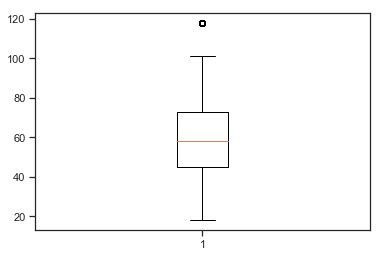

In [18]:
plt.boxplot(profile.age.values);

In [19]:
profile.loc[profile.age > 101, :].shape

(2175, 5)

In [20]:
(profile.age == 118).sum()

2175

In [21]:
profile.gender.isnull().sum()

2175

In [22]:
profile.income.isnull().sum()

2175

In [23]:
profile.became_member_on = pd.to_datetime(profile.became_member_on, format="%Y%m%d")

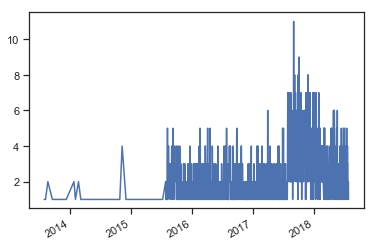

In [24]:
profile.loc[profile.age == 118, :].became_member_on.value_counts().sort_index().plot()

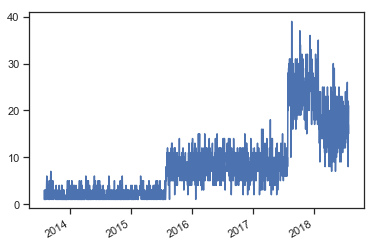

In [25]:
profile.loc[~(profile.age == 118), :].became_member_on.value_counts().sort_index().plot()

In [26]:
outlier_users = profile.loc[(profile.age == 118)]

In [27]:
transcript[transcript.person.isin(outlier_users.id)].shape[0]/transcript.shape[0]

0.11017374907840566

In [28]:
(transcript[transcript.person.isin(outlier_users.id)]["event"] == "offer completed").sum()/(transcript.event == "offer completed").sum()

0.03380088745942404

In [29]:
outlier_users.shape[0]

2175

In [30]:
profile.shape[0]

17000

In [31]:
profile = profile.drop(outlier_users.index)

### 1.4 Cleaning Data

In [32]:
portfolio.head()

,difficulty,duration,id,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


In [33]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [34]:
def cleanValue(event, value):  
    if event == "transaction":
        for key, value in value.items():
            return value
        
    items = []
    for key, value in value.items():
        items.append(value)
    if event == "offer completed":
        return items[:2]
    else:
        return items[0]

In [35]:
transactions = transcript[transcript.event == "transaction"]
transactions["transaction_amount"] = transactions.apply(lambda x: cleanValue(x['event'], x['value']), axis=1)
transactions = transactions.drop('value', axis=1)

/home/rajib/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:
transactions.head()

,event,person,time,transaction_amount
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [37]:
offer_rec = transcript[transcript.event == "offer received"]
offer_rec['offer_id'] = offer_rec.apply(lambda x: cleanValue(x['event'], x['value']), axis=1)
offer_rec = offer_rec.drop('value', axis=1)

/home/rajib/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
offer_view = transcript[transcript.event == "offer viewed"]
offer_view['offer_id'] = offer_view.apply(lambda x: cleanValue(x['event'], x['value']), axis=1)
offer_view = offer_view.drop('value', axis=1)

/home/rajib/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [39]:
offer_comp = transcript[transcript.event == "offer completed"]
offer_comp = pd.concat([offer_comp.drop('value', axis=1), pd.DataFrame(offer_comp.apply(lambda x: cleanValue(x['event'], x['value']), axis=1).tolist(),
             columns=["offer_id", "reward"], index=offer_comp.index)], axis=1)

## 2. Analyse Data

In [40]:
portfolio.head()

,difficulty,duration,id,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


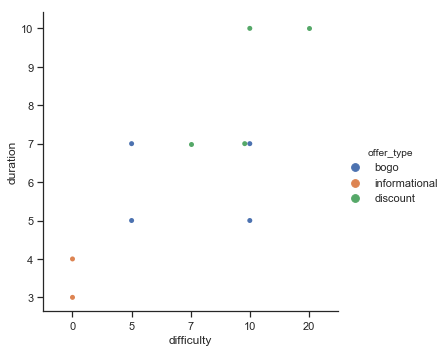

In [41]:
sns.catplot(x="difficulty", y="duration", hue="offer_type", kind="swarm", data=portfolio);

Discount seems to be more difficult

In [42]:
profile.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


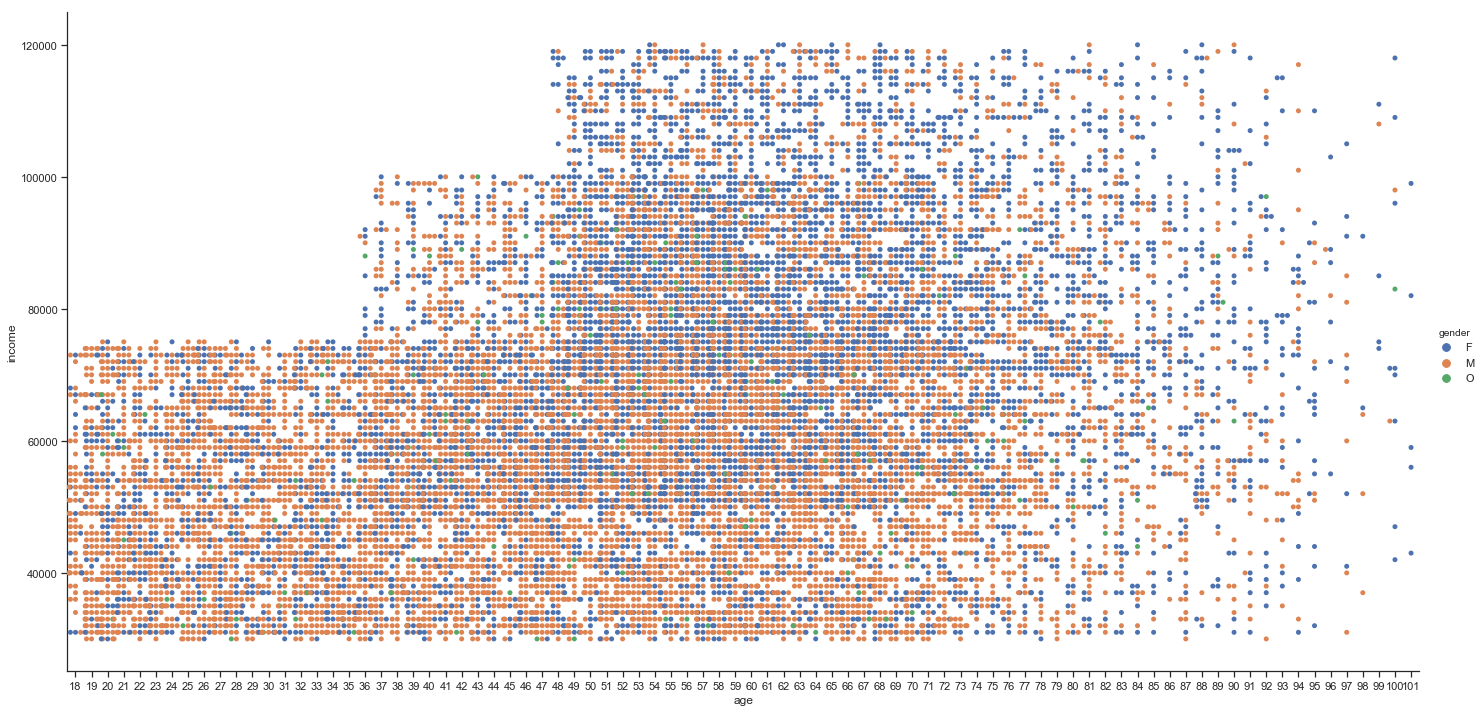

In [43]:
sns.catplot(x="age", y="income", hue="gender", kind="swarm", data=profile, height=10, aspect=2);

Female customers have comparatively more income and both male and female customers are concentrated in the middle i.e age(40-60) and salary(60000-100000)

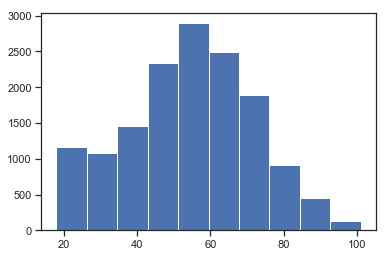

In [44]:
plt.hist(profile.age.dropna().values);

Almost a normal distribution

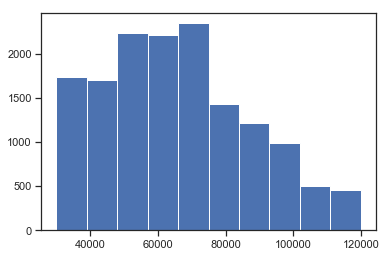

In [45]:
plt.hist(profile.income.dropna().values);

This looks like a right skewed graph

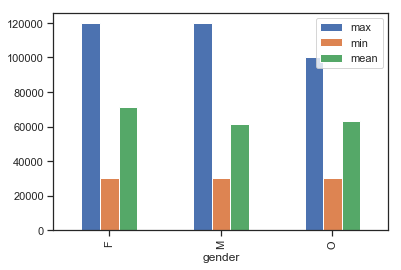

In [46]:
profile.groupby("gender")["income"].agg(["max", "min", "mean"]).plot.bar()

Not much of difference

#### Merging rec table with view table

In [47]:
merged_rec_view = pd.merge(offer_rec, offer_view, on=["person", "offer_id"], how="left").drop(["event_x","event_y"], axis=1)

In [48]:
merged_rec_view = merged_rec_view.rename(columns={"time_x":"offer_recieved_time", "time_y":"offer_viewed_time"})

#### Renaming the columns

In [51]:
merged_rec_view = merged_rec_view.rename(columns={
    "offer_recieved_time":"rec_time",
    "offer_viewed_time":"view_time",    
})

#### Merging the result of rec and view merge with portfolio table

In [54]:
offer_port_merge = pd.merge(merged_rec_view, portfolio, left_on="offer_id", right_on="id").drop("id", axis=1).sort_values(["person", "offer_id", "rec_time", "view_time"])

#### Dropping duplicate columns

In [55]:
offer_port_merge = pd.merge(offer_port_merge, offer_comp, on=["person", "offer_id"], how='left').drop(["reward_x", "event"], axis=1)

#### Renaming columns

In [56]:
offer_port_merge = offer_port_merge.rename(columns={    
    "time":"comp_time",
    "reward_y":"reward"    
})

#### Filtering only those records where the view time is greater than rec time and the gap is less than the duration of that offer and storing the result

In [58]:
offer_rec_view = offer_port_merge[(offer_port_merge.rec_time <= offer_port_merge.view_time)&
                ((offer_port_merge.view_time - offer_port_merge.rec_time)/24 <= offer_port_merge.duration)]

#### Removing the records from the main table that was in the table we created in the previous step

In [59]:
offer_rec_notview = offer_port_merge[~offer_port_merge.index.isin(offer_rec_view.index)]

In [97]:
offer_rec_notview.head()

,person,rec_time,offer_id,view_time,difficulty,duration,offer_type,channel_web,channel_email,channel_mobile,channel_social,comp_time,reward
0,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,NaN,10,7,discount,1,1,1,0,576.0,2.0
6,00116118485d4dfda04fdbaba9a87b5c,168,f19421c1d4aa40978ebb69ca19b0e20d,630.0,5,5,bogo,1,1,1,1,NaN,NaN
7,00116118485d4dfda04fdbaba9a87b5c,576,f19421c1d4aa40978ebb69ca19b0e20d,216.0,5,5,bogo,1,1,1,1,NaN,NaN
15,0020c2b971eb4e9188eac86d93036a77,504,5a8bc65990b245e5a138643cd4eb9837,660.0,0,3,informational,0,1,1,1,NaN,NaN
16,0020c2b971eb4e9188eac86d93036a77,168,ae264e3637204a6fb9bb56bc8210ddfd,NaN,10,7,bogo,0,1,1,1,NaN,NaN


#### Merging the result with offer completed table

In [98]:
offer_rec_view_comp = offer_rec_view[(offer_rec_view.comp_time >= offer_rec_view.view_time)&
            ((offer_rec_view.comp_time - offer_port_merge.rec_time)/24 <= offer_port_merge.duration)]

/home/rajib/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


#### Taking only those records where view time or comp time is not much bigger than the rec time. So we take only the min for a particular offer by a given person with a given rec time

In [99]:
final_offer_table = offer_rec_view_comp.groupby(["person", "offer_id", "rec_time"])[["view_time", "comp_time"]].agg('min')

#### Reseting the index to form a dataframe

In [100]:
final_offer_table = final_offer_table.reset_index()

#### Merging with portfoilio and profile to relate offers with users information

In [103]:
final_offer_table = pd.merge(final_offer_table, portfolio, left_on="offer_id", right_on='id').drop("id", axis=1)

In [104]:
final_offer_user_table = pd.merge(final_offer_table, profile, left_on="person", right_on="id").drop("id", axis=1)

#### Distribution of age among the users who completed the offer

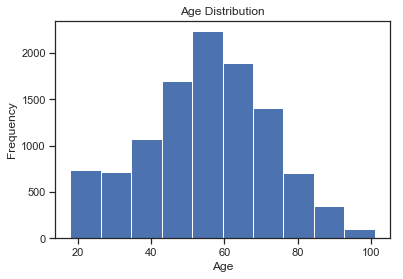

In [122]:
final_offer_user_table.groupby("person")["age"].first().reset_index()["age"].plot.hist()
plt.xlabel("Age")
plt.title("Age Distribution")
plt.savefig("age.jpg")

#### Scatter plot to relate the users age, gender and therir income

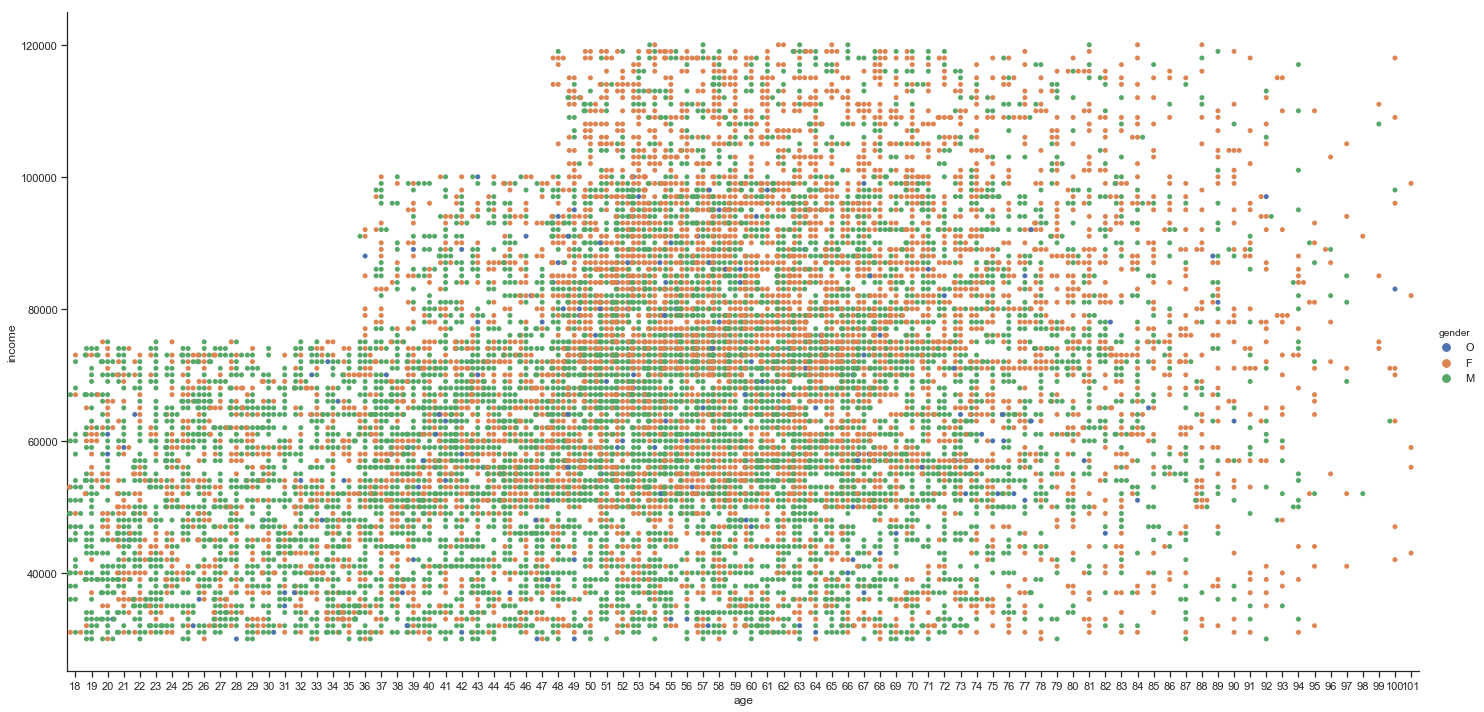

In [106]:
sns.catplot(x="age", y="income", hue="gender", kind="swarm", data=final_offer_user_table.groupby("person")[["age", "gender", "income"]].first().reset_index(), height=10, aspect=2);
plt.savefig("correlation.jpg")

#### Get gender counts in the offer completed users/

In [113]:
final_offer_user_table.groupby("person")["gender"].first().value_counts()

M    5809
F    4932
O     169
Name: gender, dtype: int64

#### Get count gender in our profile table

In [114]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

#### Getting the ratio

In [115]:
5800/8484

0.6836397925506836

In [116]:
4932/6129

0.8046989720998532

In [117]:
169/212

0.7971698113207547

#### Plotting the gender distribution

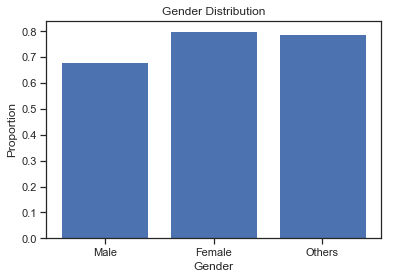

In [118]:
plt.bar(x =["Male", "Female", "Others"],height=[0.68, 0.80, 0.79])
plt.xlabel('Gender')
plt.ylabel("Proportion")
plt.title("Gender Distribution")
plt.savefig("gender.jpg")

#### Which discount type is used more

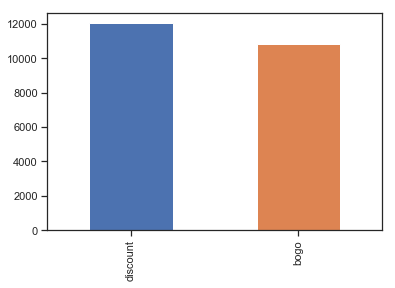

In [129]:
final_offer_user_table.offer_type_x.value_counts().plot.bar()

#### Counting number of time each user has received a particular offer

In [132]:
num_off_rec = offer_rec.groupby(["person", "offer_id"])["time"].count().reset_index()

In [133]:
num_off_rec.head()

,person,offer_id,time
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1


#### Counting number of time each user has completed a particular offer

In [134]:
num_off_comp = final_offer_user_table.groupby(["person", "offer_id"])["comp_time"].count().reset_index()

In [135]:
num_off_comp.head()

,person,offer_id,comp_time
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1


#### Merging rec time and comp time for a given offer by a given user

In [83]:
rec_time_comp_time = pd.merge(num_off_rec, num_off_comp, on = ["person", "offer_id"], how="left").fillna(0)

#### Counting number of time a user has received and  completed offers 

In [136]:
users_all_off_rec_comp = rec_time_comp_time.groupby("person")[["time", "comp_time"]].sum()

#### When user completed all the offers he got

In [85]:
(users_all_off_rec_comp.time == users_all_off_rec_comp.comp_time).sum()

586

#### When user didn't complete a single offer he got

In [137]:
(users_all_off_rec_comp.comp_time == 0).sum()

6084

In [138]:
users_all_off_rec_comp.head()

,time,comp_time
person,,
0009655768c64bdeb2e877511632db8f,5,0.0
00116118485d4dfda04fdbaba9a87b5c,2,0.0
0011e0d4e6b944f998e987f904e8c1e5,5,3.0
0020c2b971eb4e9188eac86d93036a77,5,2.0
0020ccbbb6d84e358d3414a3ff76cffd,4,3.0


#### Plotting the num of users copleted all and none of the offers they received

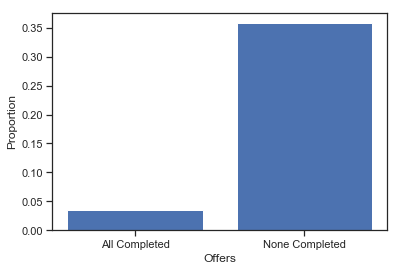

In [139]:
plt.bar(x=["All Completed", "None Completed"], height=[586/16994, 6084/16994])
plt.xlabel("Offers")
plt.ylabel("Proportion")
plt.savefig("offer_used.jpg")

#### Checking which type offer is used more

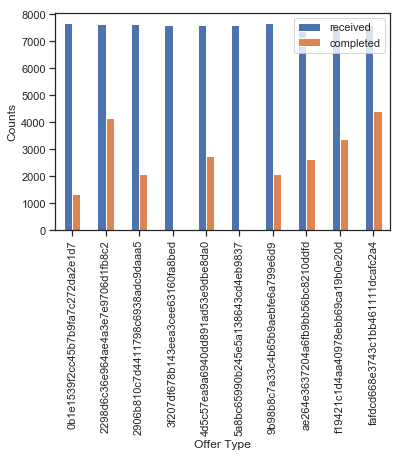

In [131]:
rec_time_comp_time.rename(columns={"time":"received", "comp_time":"completed"}).groupby("offer_id").agg({"received":"sum", "completed":"sum"}).plot.bar()
plt.xlabel("Offer Type")
plt.ylabel("Counts")
plt.savefig("offers_dist.jpg")

#### Finding users who completed offer atleast once

In [140]:
used_offers_at_once = rec_time_comp_time[~(rec_time_comp_time.comp_time == 0)]

#### Users who completed fifty percent of the offers they received

In [141]:
fifty_perc_comp = used_offers_at_once[((used_offers_at_once.time - used_offers_at_once.comp_time)/used_offers_at_once.time >= 0.5)]

In [142]:
fifty_perc_comp_users_merg = pd.merge(fifty_perc_comp, profile, left_on="person", right_on="id")

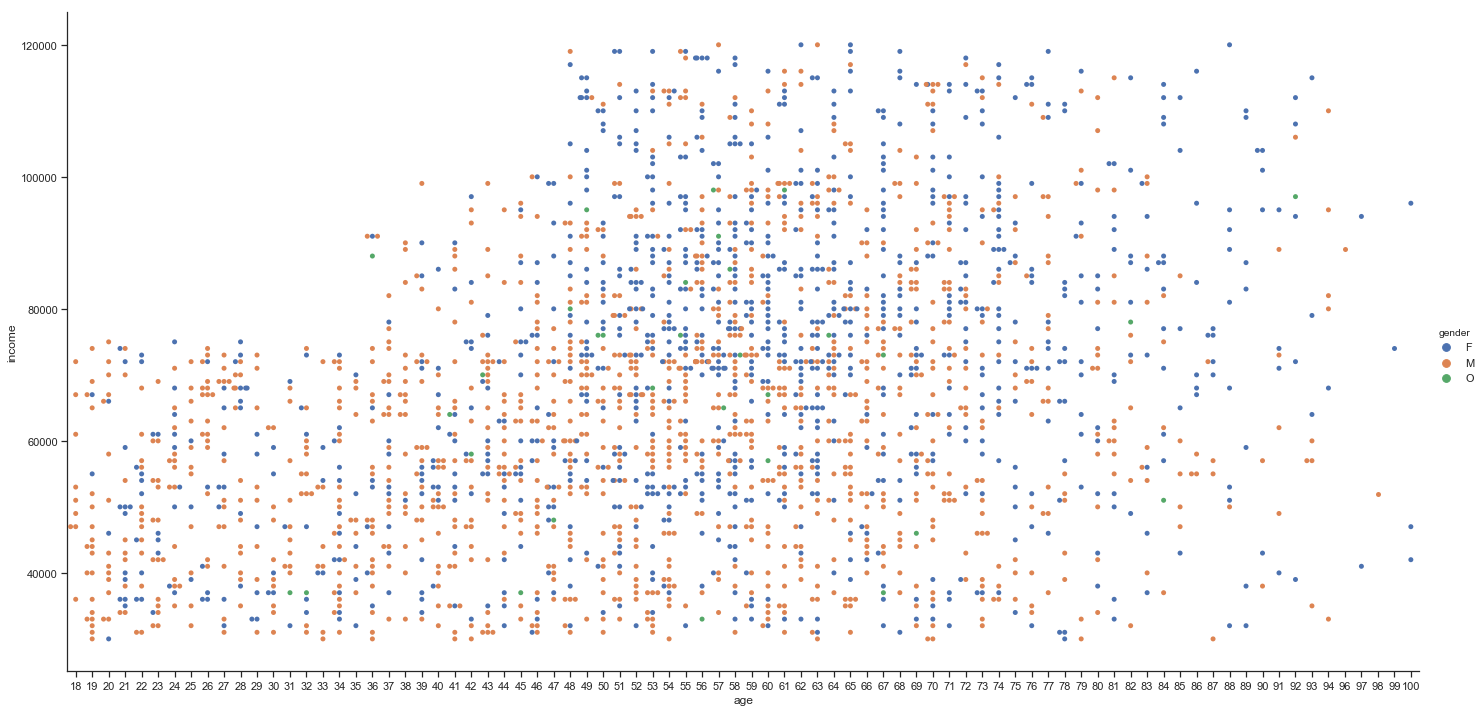

In [143]:
sns.catplot(x="age", y="income", hue="gender", kind="swarm", data=fifty_perc_comp_users_merg, height=10, aspect=2);